In [1]:
import torch
import os
import tiktoken
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import json
import os
from tqdm import tqdm
import tiktoken
import h5py
import numpy as np

device = 'mps'

In [2]:
enc = tiktoken.get_encoding('r50k_base')

In [3]:
from data_utils import get_batch_iterator

batch_size = 32
context_length = 128
train_path = "data/med_pile_train.h5"

train_batch_iterator = get_batch_iterator(train_path, batch_size=32, context_length=128)

In [4]:
xb, yb = next(train_batch_iterator)
print(xb.shape, yb.shape)
for row in xb:
    print(enc.decode(row.tolist()))
    print('\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n')

torch.Size([32, 128]) torch.Size([32, 128])
 be thought to
reduce, the defendants rely solely on the generally known facts
regarding the events of September 11, 2001, and the letters
posted in October of 2001 containing anthrax spores.7 They


       7
        Both sides in both cases agree upon the facts here earlier
reported concerning the anthrax letters. See page ___, infra. A
series of such letters was posted in October of 2001, four of
which were processed by the mail processing center in

                


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


*28*.*7*15,400*0*.*41*221*1470*790,000   PBR Plastic (m^2^/d)3,060*2*.*01*6,160*0*.*47*1,440*272*833,000***Cultivation Energy*** (***MJ/d***)**740**,**000*Cultivation Cost*** (***\$/d***)**7**,**880Cultivation GHG**\
(**g CO**~**2**~**e/d**)**64


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


²Ð¾ÑÑÐºÐ° ÑÐ¶Ðµ.. Ð° Ð²ÑÑ ÑÑÐ´Ð°Ð¶Ðµ
<tagezi> Sergey_IT: ÑÑ Ð½Ðµ Ð¿Ð¾Ð¼Ð½Ð¸ÑÑ, ÐºÐ°Ðº


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [4]:
def count_params(m):
    print(sum(p.numel() for p in m.parameters()))

In [5]:
from transformer import Transformer as MyTransformer

n_head = 8
n_embed = 128
context_length = 128
vocab_size = 50304

model = MyTransformer(
    n_head,
    n_embed,
    context_length,
    vocab_size
)
model = model.to(device)
print(model)
count_params(model)

Transformer(
  (token_embed): Embedding(50304, 128)
  (position_embed): Embedding(128, 128)
  (attn_block): Block(
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (heads): ModuleList(
        (0-7): 8 x Head(
          (key): Linear(in_features=128, out_features=16, bias=False)
          (query): Linear(in_features=128, out_features=16, bias=False)
          (value): Linear(in_features=128, out_features=16, bias=False)
        )
      )
    )
    (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (hidden): Linear(in_features=128, out_features=512, bias=True)
      (relu): ReLU()
      (proj): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=50304, bias=True)
)
13126144


In [6]:
eval_iters = 20

dev_path = "data/pile_val.h5"


@torch.no_grad()
def estimate_loss(steps):
    out = {}
    model.eval()
    for split in ['train', 'dev']:
        data_path = train_path if split == 'train' else dev_path
        batch_iterator = get_batch_iterator(data_path, 32, 128, device=device)
        losses = torch.zeros(steps)
        for k in range(steps):
            xb, yb = next(batch_iterator)
            _, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [26]:
estimate_loss(100)

{'train': tensor(4.3662), 'dev': tensor(4.4083)}

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

Train loss: 6.8661:  50%|██████████▌          | 202/400 [00:39<00:32,  6.03it/s]

Decaying lr


Train loss: 6.7520: 100%|█████████████████████| 400/400 [01:12<00:00,  5.55it/s]


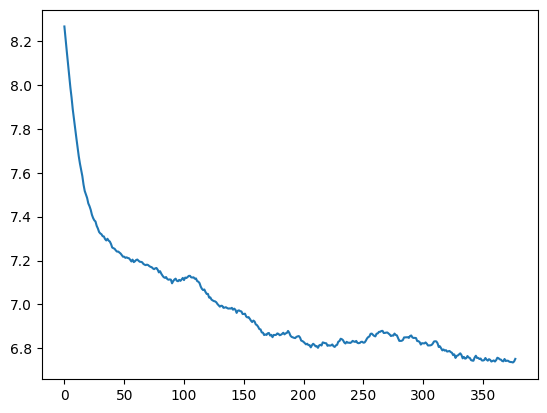

{'train': tensor(6.7389), 'dev': tensor(6.7637)}

In [23]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
context_length = 128
n_steps = 400
decay_lr_step = 200
avg_window = 64

batch_iterator = get_batch_iterator(train_path, batch_size, context_length, device=device)

pbar = tqdm(enumerate(range(n_steps)), total=n_steps)
for i, steps in pbar:
    xb, yb = next(batch_iterator)
    logits, loss = model(xb, yb)
    losses.append(loss.item())
    pbar.set_description(f"Train loss: {np.mean(losses[-avg_window:]):.4f}")
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if i == decay_lr_step:
        print('Decaying lr')
        for g in optimizer.param_groups:
            g['lr'] = 5e-5

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(losses, avg_window))
plt.show()
estimate_loss(200)

In [274]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4

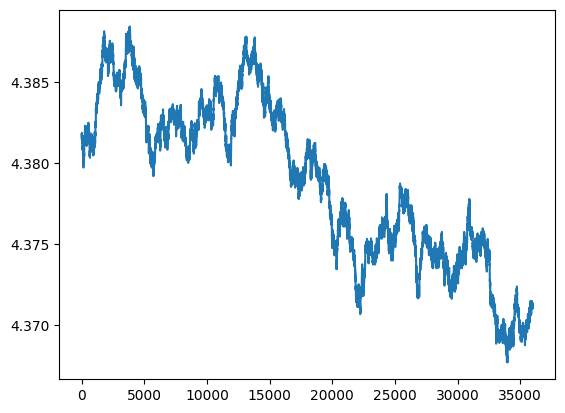

In [285]:
plt.plot(moving_average(losses[-40000:], 4000))
plt.show()

In [27]:
train_loss, dev_loss = estimate_loss(10).values()
train_loss, dev_loss

(tensor(4.2215), tensor(4.3271))

In [7]:
model_path = "/Users/jake/personal/monosemantic/models/transformer_v2_final.pt"

In [28]:
os.makedirs('models', exist_ok=True)

if not os.path.exists(model_path):
    torch.save({
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                # 'losses': losses,
                # 'train_loss': train_loss,
                # 'dev_loss': dev_loss,
                # 'steps': len(losses),
                }, model_path)

In [17]:
checkpoint['model_state_dict']['pos_idxs'] = model.state_dict()['pos_idxs']

In [8]:
checkpoint = torch.load(model_path)
# model = Transformer().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
checkpoint['steps']

KeyError: 'steps'

In [9]:
idx = torch.tensor(enc.encode('<|endoftext|>', allowed_special={'<|endoftext|>'}), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate(idx, 128)[0].tolist()))

<|endoftext|>★.Fallings motorcycle ozPhoto（
at a fat of version of “I get along that my wife’s next week—rail," MiddlemondBlue said.

United States Courses (UK)

Mark Ackermanishing) is reflected in the country, the Commander

Demos. at the Mancalysis, Robert Duffy has developed an appreciation of the Interior Cance below, incomplete, and the world contains many misconceptions to open, and possibly a comparison of an area.

Smooth War does not have created at least, in people must know which he is physical and will seem


In [11]:
from autoencoder import SparseAutoencoder

n_features = 1024

autoencoder = SparseAutoencoder(n_features, n_embed).to(device)
count_params(autoencoder)
autoencoder

1050112


SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
)

In [42]:
def get_embedding_iterator(split, batch_size, context_length=context_length):
    batch_iterator = get_batch_iterator(split, batch_size, context_length, device=device)
    while True:
        xb, _ = next(batch_iterator)
        with torch.no_grad():
            x_embedding, _ = model.forward_embedding(xb)
        random_idxs = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities
        yield filtered_xe

In [303]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [45]:
train_steps = 100000
lambda_reg = 0.0021
batch_size = 512
lr = 1e-6

autoencoder = SparseAutoencoder(1024, n_embed).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
losses = []
recon_losses = []
reg_losses = []
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
)

Recon: 0.102 Reg: 0.056: 100%|████████| 100000/100000 [6:28:22<00:00,  4.29it/s]


Loss:	0.157
Recon:	0.102
Reg:	0.055


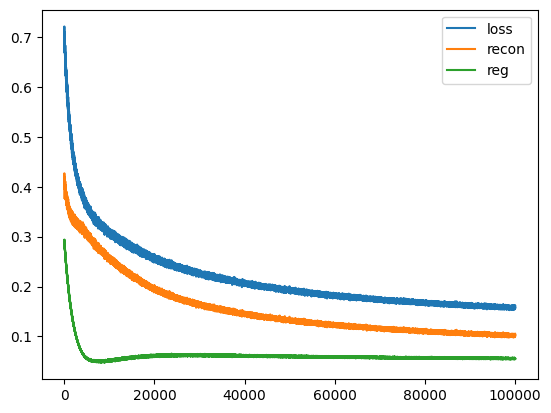

In [46]:
import matplotlib.pyplot as plt
import h5py

# train_steps = 40000
# batch_size = 512
losses = []
recon_losses = []
reg_losses = []
batch_iterator = get_batch_iterator(train_path, batch_size, context_length, device=device)

pbar = tqdm(range(train_steps))

for _ in pbar:
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = model.forward_embedding(xb)
    random_idxs = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities

    # x_embedding = next(embedding_iterator).to(device)
    optimizer.zero_grad()
    outputs, recon_loss, reg_loss = autoencoder(filtered_xe, compute_loss=True)
    reg_loss = lambda_reg * reg_loss
    loss = recon_loss + reg_loss
    loss.backward()
    optimizer.step()
    autoencoder.normalize_decoder_weights()
    
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

    pbar.set_description(f"Recon: {np.mean(recon_losses[-100:]):.3f} Reg: {np.mean(reg_losses[-100:]):.3f}")

print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses, label='loss')
plt.plot(recon_losses, label='recon')
plt.plot(reg_losses, label='reg')
plt.legend()
plt.show()

In [169]:
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
)

In [47]:
# path = "models/autoencoder_pile_2_true_1024_feats_0.003_1e-6.pt"
path = "models/autoencoder_pile_2_true_1024_feats_0.0021_1e-6.pt"

os.makedirs('models', exist_ok=True)

if not os.path.exists(path):
    torch.save({
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'steps': len(losses),
                }, path)

In [48]:
print(lambda_reg)

0.0021


In [308]:
from autoencoder import SparseAutoencoder as MySparseAutoencoder

# path = "models/autoencoder_pile_2_true_512_feats_0.003_1e-6.pt"
path = "models/autoencoder_pile_2_true_1024_feats_0.003_1e-6.pt"

checkpoint = torch.load(path)
autoencoder = MySparseAutoencoder(1024, n_embed).to(device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [39]:
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=512, bias=True)
  (decoder): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
)

In [36]:
identity = lambda x: (x, None, None)
idx = torch.tensor(enc.encode('<|endoftext|>', allowed_special={'<|endoftext|>'}), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate_ablated(idx, 128, autoencoder)[0].tolist()))

<|endoftext|>Collect Steve Gerine AWHAZ-5 s - 3, a level, in a $L on - 1, i, 2014, a weak reduction to kill a residency.
9. A once of the kind, and an old age-long pointer of the Open. I am, for the P-am failed to do the most stock of the market. The use of the third-plain hockey and bid, which is available, and hence hard. The cycling, the web means, it will fulfil Bus or to taking widely. (100) for tournament to the most partners. In the film has the same and has been


In [170]:
import matplotlib.pyplot as plt

batch_size = 512
embedding_iterator = get_embedding_iterator('train', batch_size)

def feature_density_histogram(num_samples=16384):
    all_outputs = []
    for i in tqdm(range(num_samples // batch_size)):
        batch = next(embedding_iterator).to(device)
        outputs = autoencoder.encode(batch)  # (128, 4096)
        all_outputs.append(outputs)
    all_outputs = torch.concat(all_outputs)
    return all_outputs

with torch.no_grad():
    activation_densities = feature_density_histogram(16384*10)
B, C = activation_densities.shape
activation_densities = (activation_densities > 0).to(torch.float32).mean(dim=0)
activation_densities = activation_densities[activation_densities > 0]
activation_densities = activation_densities.log10().cpu().tolist()
print(len(activation_densities)/C)
plt.hist(activation_densities, bins=48)
plt.show()

# We want nearly all features to be below 1% density: "The number of features with density above 1%. A significant number of features above this level seems to correspond to an L1 coefficient that is too low."

  0%|                                                   | 0/320 [00:00<?, ?it/s]

37402359179


 82%|█████████████████████████████████▍       | 261/320 [01:23<00:18,  3.11it/s]


KeyboardInterrupt: 

In [279]:
(activation_densities > -1).sum()

tensor(42, device='mps:0')

In [35]:
print(f"{(((activation_densities > 0).to(torch.float32).mean(dim=0) > 0).sum().item() / 4096 * 100):.2f}%")

TypeError: '>' not supported between instances of 'list' and 'int'

In [49]:
batch_size = 4096
embedding_iterator = get_embedding_iterator('data/med_pile_train.h5', batch_size, context_length)
x_embedding = next(embedding_iterator).to(device)

activation_counts = (autoencoder.encode(x_embedding) > 1e-3 * 1.0).sum(dim=-1).to(torch.float32)
print(f"Median:\t{activation_counts.median().item()}\nMean:\t{activation_counts.mean().item():.2f}\nStd:\t{activation_counts.std().item():.2f}")
# median number of hot features per token for each element in the batch, want to be "less than 10 or 20" as per paper

# "we generally target a L^0 norm that is less than 10 or 20. We especially distrust solutions where the L^0 norm is a significant fraction of the transformer’s activation dimensionality.

Median:	56.0
Mean:	55.13
Std:	10.06


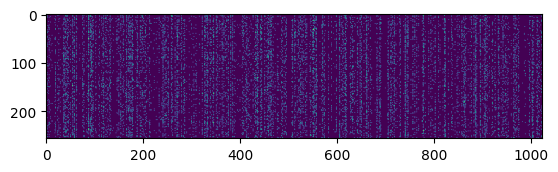

In [50]:
with torch.no_grad():
    out = autoencoder.encode(x_embedding) > 1e-3
B, C = out.shape
plt.imshow(out.cpu()[:256, :])

In [101]:
!git a && git c 'best results so far' && git push origin main

[main 653f1b9] best results so far
 1 file changed, 2523 insertions(+), 2358 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 11 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 69.38 KiB | 8.67 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/jnward/monosemanticity-repro.git
   536ef8a..653f1b9  main -> main


In [72]:
# batch_iterator = get_batch_iterator('data/med_pile_train.h5', 32, 128, device=device)
# xb, yb = next(batch_iterator)
# print(xb.shape)

with torch.no_grad():
    t_losses = []
    a_losses = []
    z_losses = []
    for _ in tqdm(range(64)):
        xb, yb = next(batch_iterator)
        t_logits, t_loss = model(xb, yb)
        a_logits, a_loss = model.forward_ablated(xb, autoencoder, yb)
        z_logits, z_loss = model.forward_ablated(xb, lambda x: (torch.zeros_like(x).to(device), 0, 0), yb)
        t_losses.append(t_loss.item())
        a_losses.append(a_loss.item())
        z_losses.append(z_loss.item())

t_loss = np.mean(t_losses)
a_loss = np.mean(a_losses)
z_loss = np.mean(z_losses)
print(t_loss, a_loss, z_loss)
print(1 - (z_loss - a_loss)/(z_loss - t_loss))

100%|███████████████████████████████████████████| 64/64 [00:09<00:00,  6.62it/s]

4.368075877428055 5.081119492650032 6.628284856677055
0.3154768527018684


In [74]:
def get_features(x):
    embedding, _ = model.forward_embedding(x)
    features = autoencoder.encode(embedding)
    return features

features = get_features(xb)

print(features.shape, xb.shape)

torch.Size([32, 128, 1024]) torch.Size([32, 128])


### Autoencoder features

In [54]:
threashold = 1e-5

num_iters = 16000
batch_size = 16
samples_per_row = 4

batch_iterator = get_batch_iterator(train_path, batch_size, 128, device=device)

def explore_features(forward_func, n_feats=512):
    feature_dict = {i: [0, []] for i in range(n_feats)}
    context_list = []
    for _ in tqdm(range(num_iters)):
        xb, _ = next(batch_iterator)
        with torch.no_grad():
            features = forward_func(xb)
        features = features.cpu()
        # print(features)
        for i, row in enumerate(xb):  # iterate thru rows in a batch
            # for j in range(row.shape[0]):  # iterate thru tokens in a row
            for j in np.random.choice(row.shape[0], samples_per_row, replace=False):  #torch.randint(row.shape[0], (samples_per_row,), replact=False):
                token = row[j]
                context = row[max(j-4, 0):j+5]
                context_list.append((token.item(), context.tolist()))
                context_idx = len(context_list) - 1
                
                feature_vec = features[i, j]
                # print(feature_vec.shape)
                activation_idxs = (feature_vec > threashold).nonzero()
                # print(activation_idxs.shape)
                # print(activation_idxs)
    
                for a_idx in activation_idxs:
                    a_idx = a_idx[0].item()
                    feature_dict[a_idx][0] += 1
                    if feature_dict[a_idx][0] < 512:
                        feature_dict[a_idx][1].append((context_idx, feature_vec[a_idx].item()))
    return feature_dict, context_list

a_feature_dict, a_context_list = explore_features(get_features, n_feats=1024)
# t_feature_dict, t_context_list = explore_features(lambda x: model.forward_embedding(x)[0])

100%|█████████████████████████████████████| 16000/16000 [07:48<00:00, 34.19it/s]


In [77]:
# sorted_dict = sorted(feature_dict.items(), key = lambda x: x[1][0] if 2000 > x[1][0] >= 4 else 0, reverse=True)
def print_features(feat_dict, ctx_list):
    sorted_dict = list(feat_dict.items())
    a = 0
    # for feat_idx, info in feature_dict.items():
    for feat_idx, info in sorted_dict[32:64]:
        count = info[0]
        if count < 100:
            continue
        ctxs = sorted(info[1], key=lambda x: x[1], reverse=True)
        ctxs = [ctx for ctx in ctxs if ctx[1] > 0]
        # ctxs = info[1]
        print(f"Feature idx:\t{feat_idx}\nCount:\t\t{count}")
        for context_idx, feature_activation in ctxs[:10]:
            token_idx = ctx_list[context_idx][0]
            token = enc.decode([token_idx])
            context = enc.decode(ctx_list[context_idx][1])
            print(f'  Token: {repr(token)}\n  Token Index: {token_idx}\n  Context: {repr(context)}\n  Activation: {feature_activation:.3f}')
            print()

In [78]:
print_features(a_feature_dict, a_context_list)

Feature idx:	33
Count:		19916
  Token: '.'
  Token Index: 13
  Context: ';\n  doc.fromHTML(content'
  Activation: 2.148

  Token: '.'
  Token Index: 13
  Context: ' = helpers.each.call(alias1'
  Activation: 2.145

  Token: '.'
  Token Index: 13
  Context: '    this.update = function('
  Activation: 2.138

  Token: '.'
  Token Index: 13
  Context: '  factoryBean.afterPropertiesSet'
  Activation: 2.078

  Token: '.'
  Token Index: 13
  Context: 'core.encoder.LayoutWrappingEnc'
  Activation: 2.073

  Token: '.'
  Token Index: 13
  Context: 'perties.UpgradeDescription.HealthPolicy.Max'
  Activation: 2.044

  Token: '.'
  Token Index: 13
  Context: 'Exception(LinkStatus.ERROR_PLUG'
  Activation: 2.039

  Token: '.'
  Token Index: 13
  Context: ' "k8s.io/kuber'
  Activation: 2.039

  Token: '.'
  Token Index: 13
  Context: ' AND production_role.role_ID ='
  Activation: 2.035

  Token: '.'
  Token Index: 13
  Context: ' + POSTendpoints.login, data:'
  Activation: 1.990

Feature idx:	36
Count:

### Transformer "features"

In [88]:
def get_feature_iterator(feat_dict, ctx_list):
    feat_items = list(feat_dict.items())
    np.random.shuffle(feat_items)
    for feat_idx, info in feat_items:
        count = info[0]
        if count < 100:
            continue
        ctxs = sorted(info[1], key=lambda x: x[1], reverse=True)
        ctxs = [ctx for ctx in ctxs if ctx[1] > 0]
        tokens = []
        contexts = []
        for context_idx, feature_activation in ctxs[:10]:
            token_idx = ctx_list[context_idx][0]
            token = enc.decode([token_idx])
            context = enc.decode(ctx_list[context_idx][1])
            tokens.append(repr(token))
            contexts.append(repr(context))
        yield tokens, contexts

transformer_feature_iterator = get_feature_iterator(t_feature_dict, t_context_list)
autoencoder_feature_iterator = get_feature_iterator(a_feature_dict, a_context_list)

In [85]:
t_feats = list(transformer_feature_iterator)
a_feats = list(autoencoder_feature_iterator)

print(len(t_feats), len(a_feats))

512 575


In [89]:
t_ratings = []
a_ratings = []
count = 0

In [90]:
while True:
    print(count)
    if np.random.randint(2):
        iterator = transformer_feature_iterator
        ratings = t_ratings
    else:
        iterator = autoencoder_feature_iterator
        ratings = a_ratings
    tokens, contexts = next(iterator)
    for token, ctx in zip(tokens, contexts):
        print(f"{token}\t\t\t{ctx}")
    count += 1
    rating = input("Rating: ")
    ratings.append(int(rating))

0
'30'			' and o.\n30\nSuppose 4'
'6'			'\n2/(-6) + (48'
'4'			' -10).\n4\nEvaluate'
' 4'			'5 + 8 - 4 - 4*s'
'72'			' what is bc972 + -7?'
' 23'			' = -s - 23. Let t be'
' 2'			' m a multiple of 2?\nTrue\n'
'6'			'ly chosen) IPv6 address from the range'
'9'			' + 40176.9'
' 17'			'). Let o = 1784/3 -'


Rating:  5


1
' image'			' apparatus in which an image treated with the Roberts'
' emitting'			's), the light emitting diodes may'
' type'			'). The site and type of injury were also'
'ocol'			' possibly per-protocol analysis, the study'
' overlay'			' end station into an overlay header that transports the'
' digital'			' of analog signal and digital signals throughout the system'
'ayer'			' an optical multilayer filter, a method'
' bundle'			' connection of the forming bundle branches (Miqu'
' memory'			' specific embodiment, this memoryless mode is used'
' size'			' coil of the needed size is made, it'


Rating:  4


2
' patients'			' The nutrient intake of patients receiving maintenance dialysis'
' fits'			' the accretion rate fits the simulated values very'
' obtained'			'. The total scores obtained from the scale were'
' hoping'			' was everything we were hoping for and more.'
' attacks'			' dealt with more cyber attacks “in the'
' out'			' the rock, giving out a dull sound;'
' patients'			' be attempted in all patients.<|endoftext|>Q:'
' schedules'			' doses plus a booster schedules only (2+'
' themselves'			' have become event films themselves, often overshadowing'
' obtained'			' the following results were obtained. 1. Select'


Rating:  3


3
'�'			'�들은 저'
' �'			'�� : v 를 �'
' �'			', 딱 보�'
'�'			'�망을 �'
' �'			'�기 바�'
'�'			'�들의 최'
' �'			'� 년 동�'
' �'			'�운 버�'
' �'			'��의 데이'
' �'			'가) 디�'


Rating:  5


4
')'			' ± 1.19)'
')'			'YCHO, obviously) along with the guilt'
')'			' (1:1000) rabbit polyclonal'
')'			' vitamin product(s) provided by *W'
')'			' α3(V) levels associated with mamm'
')'			'unit: µm)\n\n!['
')'			' nanoparticles (a) before irradiation ('
')'			'sqrt(19) + 170\nSim'
')'			'muC(V) from \\[I'
')'			' (d. 1951)\n1895 –'


Rating:  5


5
' whereas'			'K3 inhibition), whereas in the upstream of'
'),'			'APK3 inhibition), whereas in the upstream'
','			' conflicting results. Nevertheless, the studies with statistically'
' that'			'-infected neurons that expressed TNF-'
' and'			' *in vitro* and in cell systems indicate'
','			' by the mitochondria, which released cyto'
'],'			'00162]\\], while *G.'
' thus'			'"}). The model thus, until to this'
';'			' CD-1 mouse; (**C**'
','			' in several human cancers, including leukem'


Rating:  2


6
' I'			", and just because I haven't found anything"
' I'			' I want the way I live my life to'
' sprint'			' started training for a sprint triathlon. I'
' Br'			'aja’s Brute speak of brutality'
' Arch'			' the stainless steel Gateway Arch in St. Louis'
'Ar'			' wireless?\n<Arrick> Someone needs'
' ind'			' exemplo, na indústria do'
' $'			'\n\n// setting $st and $tree'
'pt'			' parties negotiate prenuptial agreements very close'
' PC'			', not reported; PCA, principal component'


Rating:  1


7
' till'			' mangel på tillid mellem par'
's'			'elig løsning baseret p'
'm'			' ölümlerin\nb'
't'			' och i framtiden. Vi fr'
'ige'			'ye Veier villige til å pr'
' et'			'å nytt etter den fø'
't'			' målsætninger, vi'
'e'			'�nnu inte fallet i m'
' d'			'ösen, die das Leben Euro'
' vill'			' Nye Veier villige til å'


Rating:  5


8
'je'			' euroobligacje są te'
','			'4, Orc4, Osbpl11'
','			' qwerty1, most laptops are compatible'
','			' biggest value in 208, -6, -'
' -'			'culate -14 - ((-143)/'
'),'			', Montgomery, USA), p65 (ab'
','			'11fip3, Rab1a,'
' -'			')/(6 + -4).\n-'
'00'			'a28a2800a28a28'
'-'			' 5 through a lag-lead filter circuit 4'


Rating:  1


9
'17'			'00,1291421700 \n04'
'27'			'acb224c273897b24'
'72'			' what is bc972 + -7?'
'9'			'363c4a9b1601'
'22'			' progress note 2/22/96, West'
' 100'			'ToUnits: 100\n  spriteBorder'
' 4'			'.  See bug 4697245!\n'
'7'			'4, 0x7f0100a5'
'28'			' minutes after 2:28 PM?\n12'
'12'			' \n04/12/2010 00:'


Rating:  5


10
' patients'			' be attempted in all patients.<|endoftext|>Q:'
' value'			'D*\\* value under normal growth conditions'
' treatment'			' to treatment and/or treatment'
' poems'			' but also, these poems are a rhaps'
'rogen'			' Carbon monoxide dehydrogenase and the ['
' waters'			'*) and lotic waters (*E. polit'
' Quebec'			', which was behind Quebec last year while Ontario'
' 15'			' to Friday, March 15, 2019 (All'
' medals'			', winning Connacht medals in 1979 and 1981'
' people'			' people were fighting over rock'


Rating:  2


11
' of'			'fulness on the order of $3\\%'
' of'			' are usually the result of several more innocent occurrences'
' of'			' if one or more of those organisms was/'
' of'			' benefits for the remainder of 2004. After requesting'
' of'			', both are capable of being totalitarians'
' of'			', which extracted some of the cigarette smoke while'
' of'			' action during the invasion of Poland. The unit'
' of'			'\nIn the presence of'
' of'			' be expected that most of the utterances in'
' of'			' prevention rather than cure of misuse, and the'


Rating:  5


12
')'			' areas (NPAs) is related to uncontrolled'
','			', the suit says, Floyd met with the'
','			' v. Gerhardt, 206 Wis. 358'
','			' and ratified in 1949, which with three more'
','			' Figure 3.17, where we examine the'
','			', Tokyo, Japan, respectively). The N'
','			' to higher field scales, only the kink'
' is'			'3}$, which is an irred'
'}'			'^{\\dagger}_{\\sigma'
','			' of their corporate strategy, to housing developers,'


Rating:  2


13
' -'			' + 101*v - 5*i +'
' +'			' -4*h + 3*x,'
' +'			' -4*b + 3*f -'
' +'			' -26*b + 167674 = -'
' +'			' -2*w + s + 1.'
' -'			' -5*l - 37 + 12 ='
' +'			' -2*g + 5236. Is'
' -'			' 10, -f - 2 = t.'
' -'			' b - 10 = -2*x,'
' -'			' - 9566 = -12*'


Rating:  5


14
' be'			' 8. Let y be z(-8).'
' be'			'5\nLet r be (-3 - 0'
' be'			'3). Let u be 1*(2'
' be'			'l. Let v be u(3).'
' be'			' h(t) be the second derivative of'
' be'			'11\nLet g be (-250)/(-'
' be'			' c(p) be the first derivative of'
' ='			'True\nLet q = -113 + 95'
' ='			' h(u) = -u + 2'
' ='			' l(g) = -9*g'


Rating:  5


15
' first'			'\n\nFor the first and second generations of'
' Following'			'glycan processing. Following negative-selection,'
' Here'			' a goroutine. Here’s a'
' '			'igenvalues.\n\n    [**'
' individuals'			'D).  For individuals desiring to jud'
','			'ence proof. Therefore, $(\\mu,'
'In'			' performed.\n\nIn view of the long'
' variation'			'. By measuring the variation of oscillation amplitude'
' '			' ---------------------------\n     '
' Among'			' the finally study. Among those people, 408'


Rating:  1


16
' Ali'			'-team coach, Ali Reza Mehr'
'b'			' [@b21]; [@'
'K'			' authors in [@KroReiTh'
'W'			'2009ip; @Waelkens:2008'
'ool'			'const CSettingBool>((*setting'
'ical'			'Props[logical'
'j'			"t','5','j');\narray('"
' Mary'			'\ndear Miss Mary had been weak and'
'r'			'{\\lambda}},r,s),\\'
' she'			' death on hearing that she had complained of a'


Rating:  2


17
' -'			'culate -14 - ((-143)/'
' -'			')/(6 + -4).\n-'
'rox'			'pace\n<zenrox> whats the least'
','			' biggest value in 208, -6, -'
'frac'			'1}dt\\frac{dx}{y'
'\n'			's &\\sim\n  \\frac{'
'rox'			' hack\n<zenrox> becides blank'
' 69'			" limited only by § 6972(b)'"
' Since'			' flunkies. Since mergers generally require'
'-'			'CI 5.9-36) \\[['


Rating:  2


18
'�'			' “You can’t just requ'
'�'			'\nAnd I can’t do that'
'�'			' 1967 when that year’s Criminal Law'
'�'			' outcome: I don’t think many'
'�'			' smoke. I didn’t smoke before'
'�'			' time. I don’t even know'
'�'			', so I didn’t make any'
'�'			'\nYeah, it’s especially cold'
'�'			' said that I don’t really care'
'�'			', my tracks don’t have enough'


Rating:  5


19
'ances'			'\ncircumstances attributed to her mother'
' residence'			". Bolter's residence is in Tarry"
' granted'			'\n\n\nPetition granted and remanded by'
' practice'			'ice\n\nFirst practice \nKyle Larson'
'ination'			'.#--Imagination is the power of'
' complaint'			' week later, the complaint alleges, state party'
' support'			'. 2004), as support for its decision.'
' practice'			' .\n\nFinal practice \nDale'
' poisoning'			' and carbon monoxide poisoning. For 2005,'
' attorney'			' to the question of attorney fees. While discovery'


Rating:  2


20
' '			'Image();\n      };'
' '			"cluster',\n   "
' '			'LocationChanged;\n    }\n'
' '			'  return;\n     '
' '			' //\n       '
' '			' "text",\n     '
' '			'  }\n    schema3,'
' '			" })\n    .controller('contact"
' '			' [\n       '
' '			'  },\n      '


Rating:  5


21
" '"			"\t\ttype: 'string',\n\t"
'://'			'up\n\nhttps://en.wikipedia.'
'/'			'pmjs.org/compressible/-'
'/'			'/tree/master/src/k8'
' "'			'     "kiss carry display unusual'
"('"			"ByteString.includes('\\u0395"
'/'			'lemach.si/pdf/navod'
'/'			'reyaspatil/MaterialDialog/Abstract'
'pkg'			'imachinery/pkg/runtime"\n'
'://'			' NIT ( http://www.nitlanguage'


Rating:  5


22
' goes'			'” (he goes\non more sens'
' sought'			" technology. I've sought to widen the Performance"
' seem'			'lipperiness would seem a disadvantage, experience'
' take'			' feeling like they could take their experience elsewhere in'
' run'			'_iii> will run that now... wish'
' be'			'ines until you shall be legally discharged ?\n'
' can'			'. The acquiring corporation can avoid having to get'
' come'			' was; he had come from the Stasi'
' questions'			' computer, will answer questions, help fill out'
' go'			'van, you can go home for the day'


Rating:  3


23
','			' 128 of its report, which explains how the'
' and'			' Green, Blue, and Red Rooms also acquired'
' ['			'bib27], [@bib28'
','			' on, and has, subsequently, been allowed'
','			'\n\n"Oh, I just love this'
','			' clearly not done so, with serious consequences.'
','			' low to begin with, they simply tested poorly'
' and'			's of Germany, and Erich Tsc'
' and'			' reading, ritual, and emergent documentation.'
' ('			' Fundamental Physics” (University of Chicago Press'


Rating:  4


24
' '			' </div>\n     '
' '			'</xml>\n     '
' '			'\\n",\n     '
' '			'  break;\n     '
' '			'getInstance();\n     '
' '			'         '
' '			'?error")\n     '
' '			'upSource"\n     '
' '			'         '
' '			'\n        '


Rating:  5


25
' ,'			'ton on Burton_ , ed. Mark Sal'
' '			').\n\n      Due to'
' '			'         '
','			'iebuhr, "Hazards'
' '			'      III. ASSIGN'
' à'			' frappèrent à la porte et'
' '			'\n\n      Due to STATE'
' '			'         '
' '			'igenvalues.\n\n    [**'
' '			'         '


Rating:  2


26
'2'			'\n2\n\n2\n\nTomatoes'
'r'			'g kjærligheten bob'
'\n'			'ough, Bernard Kay\n\n93m\n'
'let'			'ligheten boblet i blodet'
'Car'			'\n1\n\nCarrots\n\n2'
'\n'			'atoes\n\n2\n\n2\n\n'
'M'			'fr.\n\nMona collabore'
'8'			'derived,\n\n8\n\npept'
' Me'			'\n Eliete Mejor'
'\n'			'\n\n2\n\n2\n\nBro'


Rating:  3


27
' obtained'			' the following results were obtained. 1. Select'
'.'			'autuksen. On tarpeen'
' differs'			' minutes). This result differs from that of previous'
' to'			'IF antibody was due to the development of insulin'
' obtained'			'o-Pen readings obtained from various locations,'
'oped'			' of H. seropedicae recovered from'
' amplify'			'atin, which can amplify the Raman'
' is'			'S4] and is activated by addition of'
' be'			' an amount sufficient to be effective.\nA'
' For'			' with specific compounds. For instance, melatonin'


Rating:  1


28
' grounded'			' fiction has been traditionally grounded. Yet her definition'
' fabric'			' lying, fabricating evidence, and'
'ues'			' gather without spawning intrigues worthy of the Prince'
' aur'			'\n"[Il] aurait accepté".'
'otion'			' of his\nemotion. He uttered no'
' set'			' may be to use set methods:\n>>>'
' toward'			' away from, not toward, Lovecraft; it'
' account'			' out of the trust account. Within three months'
'amed'			"f's face beamed with an almost un"
' forgive'			' God to understand and forgive me.\n\n'


Rating:  1


29
'?"'			' me to run in?" Georgina said.'
'?"'			' a little more besides?"\n\nForrest'
'?"'			' this week, huh?" "To defend my'
'."'			' prisoner, like yourself." "But together,'
'."'			' whose word you trust." "I promise you'
' worry'			'." "Don\'t worry, my boy..."'
'!"'			' on him, too!"\n\nJeff pushed'
' to'			' Together, they went to see the others,'
'."'			' unit ready for Miller."\n\n"That'
' do'			' don\'t have to do that." " You'


Rating:  2


30
' I'			" upon a question that I can't seem"
' I'			' an example, suppose I am writing about a'
' I'			' issues as in Higgins I, II, and'
' I'			" a different identity. I don't know what"
' I'			'\nOver the weekend I had been listening to'
' I'			' people are using? I enjoy gnome-'
' I'			' with that, that I am constrained in time'
' I'			' into making decisions that I didn’t'
' I'			' site. The reason I wanna bring up St'
' I'			' next time. I feel that this next'


Rating:  5


31
' irresistible'			'pelled by a sudden irresistible curiosity.\n\n'
'ill'			' and even\nbrill'
' gorgeous'			'ren. He was gorgeous with his hair sl'
'red'			' and especially Gloria Allred,” Trump'
' dependent'			' only a single position dependent HF coupling was introduced'
' resilient'			' used strategy must be resilient against abuse. When'
' clear'			'�s a pretty clear setup in the game'
' visible'			'. This condition becomes visible only once 250 hours'
'ated'			' wild tigers are annihilated on the other side'
'upid'			'<|endoftext|>Neoleleupidia\n\nNe'


Rating:  2


32
' and'			' position in PPP and his faction was liquid'
' the'			'\n\nAccess to the Statement Date for corporate'
' and'			'.\n\nMr and Mrs P G D'
' and'			' down in the dirt and summoned the best fake'
' scraps'			' Keckley saved scraps from the dozens of'
' and'			' the postman knocked and presented him with his'
' and'			": Olympic Sex Testing and the Category 'Woman"
' the'			' the car. While the Red "Sens'
' Indians'			' as the Greeks and Indians and longed for'
' granted'			'\n\n\nPetition granted and remanded by'


KeyboardInterrupt: Interrupted by user

[]

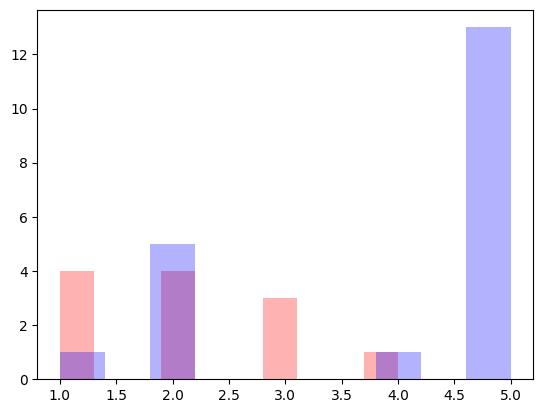

In [91]:
import matplotlib.pyplot as plt

plt.hist(t_ratings, color='red', alpha=0.3)
plt.hist(a_ratings, color='blue', alpha=0.3)
plt.plot()

In [92]:
t_ratings, a_ratings

([3, 1, 1, 2, 1, 2, 3, 4, 2, 3, 1, 2],
 [5, 4, 5, 5, 2, 5, 5, 5, 2, 5, 5, 2, 5, 2, 5, 5, 5, 1, 2, 5])

In [5]:
import zstandard as zstd
import json

# Path to your .jsonl.zst file
file_path = '/Volumes/External/EleutherAI_ThePile_v1/pile/val.jsonl.zst'

# Open the compressed file
with open(file_path, 'rb') as compressed:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed) as reader:
        while True:
            chunk = reader.read(65536)  # Read a chunk of data
            if not chunk:
                break
            # Process chunk (which is a part of your decompressed data)
            for line in chunk.splitlines():
                json_data = json.loads(line.decode('utf-8'))
                break
            break
                # Process your json_data here

{'pile_set_name': 'OpenWebText2'}


In [181]:
!git a && git c "scripts for using the pile"


[main f8ebab5] scripts for using the pile
 1 file changed, 404 insertions(+), 4868 deletions(-)
